# In this notebook, I'm going to practice a powerful technique called transfer learning and be replicating a machine learning research paper.

Course practice: https://github.com/mrdbourke/pytorch-deep-learning

## Imports

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch import nn

import torchvision
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

from pathlib import Path
import requests
import zipfile
import os
from tqdm.auto import tqdm
from timeit import default_timer as timer
from PIL import Image
import random
from typing import Tuple, Dict, List

In [ ]:
try:
    from torchinfo import summary
except:
    !pip install torchinfo
    from torchinfo import summary

## Usful class and basic setup

In [ ]:
class Helper():

    def __init__(self, device: torch.device):
        self.device = device

    def download_data(self,
                      source: str,
                      destination: str,
                      remove_source: bool=True) -> Path:

        # Path to data folder
        data_path = Path('data/')
        image_path = data_path / destination

        # If image folder doesn't exist, dowload and prepare it
        if image_path.is_dir():
            print(f'{image_path} is already exists')
        else:
            print(f'Did not find {image_path} directory, creating it')
            image_path.mkdir(parents=True, exist_ok=True)

            # Download data from source
            target_file = Path(source).name

            with open(data_path / target_file, 'wb') as f:
                request = requests.get(source)
                print(f'Downloading {target_file} form {source}')
                f.write(request.content)

            # Unzip data from target file:
            with zipfile.ZipFile(data_path / target_file, 'r') as zip:
                print(f'Unzipping {target_file}')
                zip.extractall(image_path)

            if remove_source:
                os.remove(data_path / target_file)

        return image_path

    def create_dataloaders(self,
                           train_dir: str,
                           test_dir: str,
                           transform: transforms.Compose,
                           batch_size: int,
                           num_workers: int=os.cpu_count()):

        # Create custom datasets by using ImageFolder
        train_dataset = datasets.ImageFolder(train_dir, transform=transform)
        test_dataset = datasets.ImageFolder(test_dir, transform=transform)

        # Get class names
        class_names = train_dataset.classes

        # Turn images into data loaders
        train_dataloader = DataLoader(dataset=train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      num_workers=num_workers,
                                      pin_memory=True
                                      )
        test_dataloader = DataLoader(dataset=test_dataset,
                                     batch_size=batch_size,
                                     shuffle=False,
                                     num_workers=num_workers,
                                     pin_memory=True)

        return train_dataloader, test_dataloader, class_names

    def set_seeds(self, seed: int=42):

        # Set the seed for general torch operations
        torch.manual_seed(seed)

        # Set the seed for CUDA torch operations (ones that happen on the GPU)
        torch.cuda.manual_seed(seed)

    def train_step(self,
                   model: torch.nn.Module,
                   dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   device: torch.device) -> Tuple[float, float]:

        # Put model in train mode
        model.train()

        # Setup train loss and train accuracy
        train_loss, train_accuracy = 0, 0

        # Loop through data loader data batches
        for batch, (X, y) in enumerate(dataloader):

            # Send data to device
            X = X.to(device)
            y = y.to(device)

            # Forward pass
            y_pred = model(X)

            # Calculate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            # 3 must have
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_accuracy += torch.eq(y_pred_class, y).sum().item() / len(y)

        # Adjust metrics to get average loss and accuracy per batch
        train_loss /= len(dataloader)
        train_accuracy /= len(dataloader)

        return train_loss, train_accuracy

    @torch.inference_mode()
    def test_step(self,
                  model: torch.nn.Module,
                  dataloader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  device: torch.device) -> Tuple[float, float]:

        # Put model in eval mode
        model.eval()

        # Setup test loss and test accuracy
        test_loss, test_accuracy = 0, 0

        # Loop through data loader data batches
        for batch, (X, y) in enumerate(dataloader):

            # Send data to device
            X = X.to(device)
            y = y.to(device)

            # Forward pass
            y_pred = model(X)

            # Calculate loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            # Calculate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_accuracy += torch.eq(y_pred_class, y).sum().item() / len(y)

        # Adjust metrics to get average loss and accuracy per batch
        test_loss /= len(dataloader)
        test_accuracy /= len(dataloader)

        return test_loss, test_accuracy

    def train(self,
              model: torch.nn.Module,
              train_dataloader: torch.utils.data.DataLoader,
              test_dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              epochs: int,
              device: torch.device) -> Dict[str, List[float]]:

        res = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

        # Loop through training and testing steps for a number of epochs
        for epoch in tqdm(range(epochs)):
            train_loss, train_accuracy = self.train_step(model=model,
                                                         dataloader=train_dataloader,
                                                         loss_fn=loss_fn,
                                                         optimizer=optimizer,
                                                         device=device)
            test_loss, test_accuracy = self.test_step(model=model,
                                                      dataloader=test_dataloader,
                                                      loss_fn=loss_fn,
                                                      device=device)

            # Logs
            print(f'Epoch: {epoch + 1} | '
                  f'train loss: {train_loss:.4f} | '
                  f'train accuracy: {train_accuracy:.4f} | '
                  f'test loss: {test_loss:.4f} | '
                  f'test accuracy: {test_accuracy:.4f}')

            # Update results
            res['train_loss'].append(train_loss)
            res['train_acc'].append(train_accuracy)
            res['test_loss'].append(test_loss)
            res['test_acc'].append(test_accuracy)

        return res

    def plot_loss_accuracy_curves(self, results: Dict[str, List[int]]):

        # Get train loss, test loss, train accuracy, test accuracy from dict
        train_loss = results['train_loss']
        train_accuracy = results['train_acc']
        test_loss = results['test_loss']
        test_accuracy = results['test_acc']

        # Figure out how many epochs there are
        epochs = range(len(train_loss))

        # Setup the plot
        plt.figure(figsize=(15, 7))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, label='Train loss')
        plt.plot(epochs, test_loss, label='Test loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracy, label='Train accuracy')
        plt.plot(epochs, test_accuracy, label='Test accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.legend()

    @torch.inference_mode()
    def predict_and_mb_plot(self,
                            model: torch.nn.Module,
                            image_path: str,
                            class_names: List[str],
                            device: torch.device,
                            image_size: Tuple[int, int]=(224, 224),
                            transform: torchvision.transforms=None,
                            make_plot: bool=False):

        # Open Image
        image = Image.open(image_path)

        # Create transformation for image
        if transform:
            image_transform = transform
        else:
            image_transform = transform
            image_transform = torchvision.transforms.Compose([transforms.Resize(image_size),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize(mean=[.485, .456, .406],
                                                                                  std=[.229, .224, .225])])

        # Predict label (class)
        # Make sure the model is on the target device
        model.to(device)

        # Put model to eval mode
        model.eval()

        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(image).unsqueeze(dim=0)

        # Calculate logits on image with an extra dimension and send it to the target device
        logits = model((transformed_image).to(device))

        # Calculate probability and make a prediction
        probability = torch.softmax(logits, dim=1)
        predicted = torch.argmax(probability, dim=1)

        # Plot image with predicted label and probability
        if make_plot:
            plt.figure()
            plt.imshow(image)
            plt.title(f'Pred: {class_names[predicted]} | Prob: {probability.max():.3f}')
            plt.axis(False)
        else:
            return predicted, torch.round(probability.max(), decimals=3)

    def save_model(self,
                   model: torch.nn.Module,
                   target_dir: str,
                   model_name: str):

        # Create target directory
        target_dir_path = Path(target_dir)
        target_dir_path.mkdir(parents=True,
                              exist_ok=True)

        # Create model save path
        assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
        model_save_path = target_dir_path / model_name

        # Save model's state_dict()
        print(f'Model saved in {model_save_path}')
        torch.save(obj=model.state_dict(),
                   f=model_save_path)

    @torch.inference_mode()
    def make_prediction(self,
                        model: torch.nn.Module,
                        data: list,
                        device: torch.device) -> torch.Tensor:

        probs, preds = [], []
        model.eval()
        if type(data[0]) is tuple:
            data = [data[i][0] for i in range(len(data))]
        for sample in data:
            # Add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
            sample = torch.unsqueeze(sample, dim=0).to(device)
            # Calculate logits on image with an extra dimension and send it to the target device
            logits = model(sample)
            # Calculate probability
            probability = torch.softmax(logits, dim=1)
            probs.append(probability.cpu())
            predicted = torch.argmax(probability, dim=1)
            preds.append(predicted.cpu())

        # Stack probabilities and predictions into tensors
        probs = torch.cat(probs, dim=0)
        preds = torch.cat(preds, dim=0)

        return probs, preds

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
helper = Helper(device)

In [ ]:
# Create global variables
BATCH_SIZE = 32
NUM_CLASSES = 3
IMG_SIZE = 224
OUT_SHAPE = 768

## Block 1: transfer learning practice

### How it works? Intro

I'm going to use custom data, which consists of three classes: pizza, sushi and steak, in a prepared efficientnet_b0 model

First, let's figure out what data the prepared model is used to working with

This is necessary in order for our data loaders to synthesize data comparable to the original ones, because it was on this data format that the pretrained model was trained

All pretrained models expect that the input images will be normalized in the same way, i.e. mini-packages of 3-channel RGB images of the shape (3 x H x W) will be presented, where H and W must be at least 224

The images should be loaded in the range [0, 1] and then normalized using the mean value = [0.485, 0.456, 0.406] and the standard value = [0.229, 0.224, 0.225]

In [ ]:
# Let's create paths for training and testing directoreis
image_path = helper.download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
                                  destination='pizza_steak_sushi')

train_dir = image_path / 'train'
test_dir = image_path / 'test'

data/pizza_steak_sushi is already exists


In [ ]:
# Let's create a custom transformation that prepares the input data for the correct representation
custorm_transform = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[.485, .456, .406],
                                                             std=[.229, .224, .225])])

In [ ]:
train_dataloader, test_dataloader, class_names = helper.create_dataloaders(train_dir=train_dir,
                                                                           test_dir=test_dir,
                                                                           transform=custorm_transform,
                                                                           batch_size=BATCH_SIZE)

In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # .DEFAULT means the best available weights from the pretraining from ImageNet
model = torchvision.models.efficientnet_b0(weights=weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 120MB/s] 


In [ ]:
# To see what data transformations were in the model, we can use:
weights.transforms()
# And use it in DataLoader(...,transform=)
# But since we've already written a manual conversion, let's use it

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Let's see the structure of our model
summary(model=model,
        input_size=(32, 3, 224, 224),  # [batch_size, channels, height, weight]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
# Now let's freeze all the base layers (features) and rewrite the classifier
for param in model.features.parameters():
    param.requires_grad = False

# Necessary for stable reproduction
helper.set_seeds()

# in_featers = number of objects from the last untrained layer
# out_featuers = number of classes
model.classifier = nn.Sequential(nn.Dropout(p=0.2,
                                            inplace=True),
                                 nn.Linear(in_features=1280,
                                           out_features=NUM_CLASSES,
                                           bias=True)).to(device)

# Let's look at the architecture of the model after this change
summary(model=model,
        input_size=(32, 3, 224, 224),  # [batch_size, channels, height, weight]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [ ]:
# Train our mdel
helper.set_seeds()

start = timer()
res = helper.train(model=model,
                   train_dataloader=train_dataloader,
                   test_dataloader=test_dataloader,
                   loss_fn=loss_fn,
                   optimizer=optimizer,
                   epochs=5,
                   device=device)
print(timer() - start)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train loss: 0.6940 | train accuracy: 0.8789 | test loss: 0.7277 | test accuracy: 0.8665
Epoch: 2 | train loss: 0.7657 | train accuracy: 0.7266 | test loss: 0.6448 | test accuracy: 0.8968
Epoch: 3 | train loss: 0.6051 | train accuracy: 0.9062 | test loss: 0.5394 | test accuracy: 0.8864
Epoch: 4 | train loss: 0.6618 | train accuracy: 0.7227 | test loss: 0.5016 | test accuracy: 0.8968
Epoch: 5 | train loss: 0.5391 | train accuracy: 0.8945 | test loss: 0.5257 | test accuracy: 0.9280
167.3438961519987


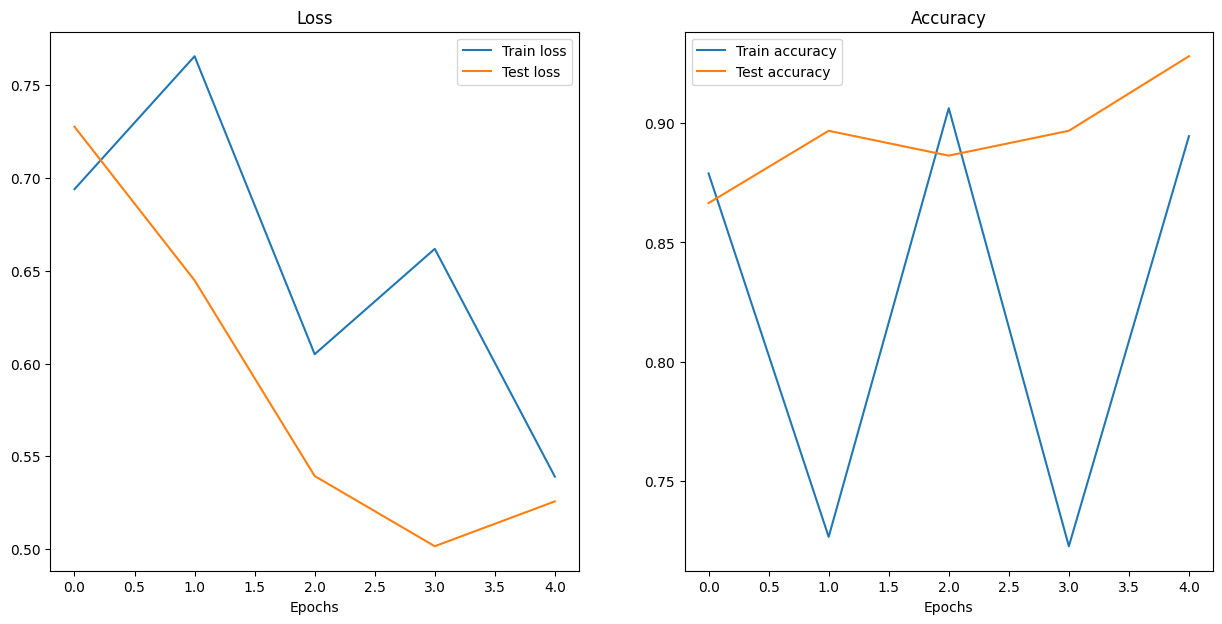

In [ ]:
helper.plot_loss_accuracy_curves(res)

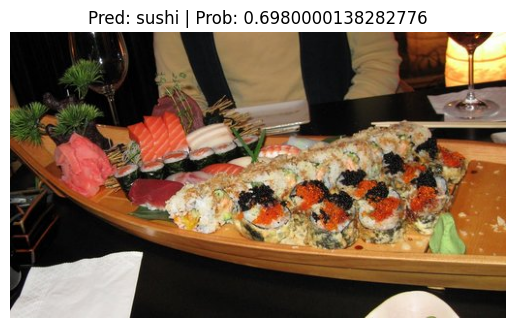

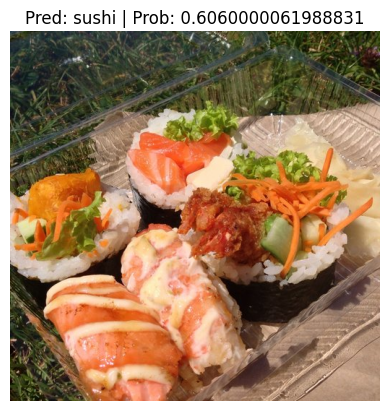

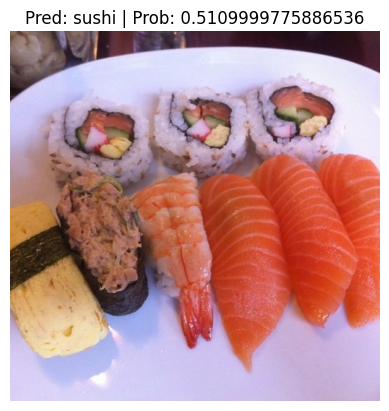

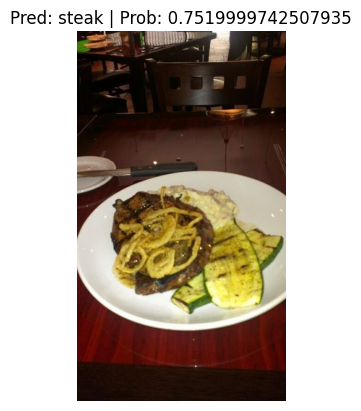

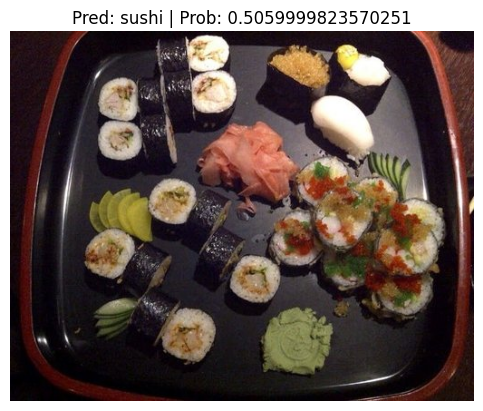

In [ ]:
# Make a prediction for random test images
# Generate n random images
n = 5
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=n)

for image_path in test_image_path_sample:
    helper.predict_and_mb_plot(model=model,
                               image_path=image_path,
                               class_names=class_names,
                               device=device,
                               make_plot=True)

In [ ]:
# Let's predict most wrong
path_prob = {}

test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))

for image_path in test_image_path_list:
    prob = helper.predict_and_mb_plot(model=model,
                                      image_path=image_path,
                                      class_names=class_names,
                                      device=device,
                                      make_plot=False)
    path_prob[image_path] = prob

In [ ]:
list_path_prob = list((k, v) for k, v in sorted(path_prob.items(), key=lambda item: item[1][1]))

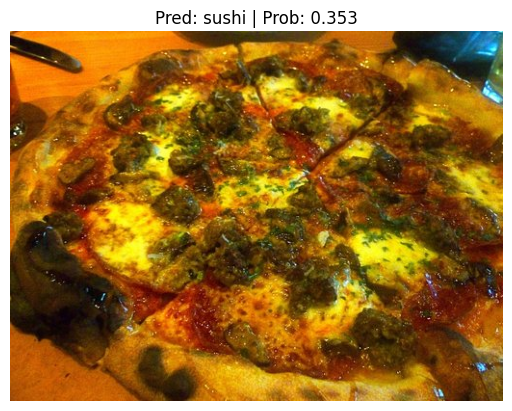

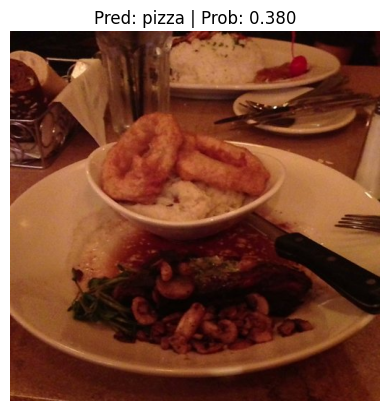

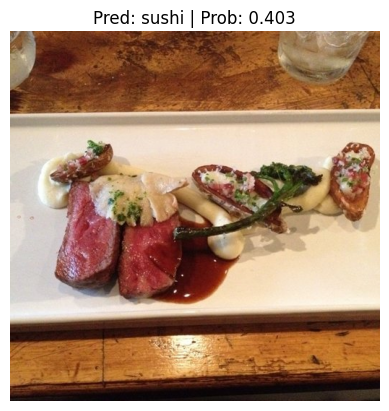

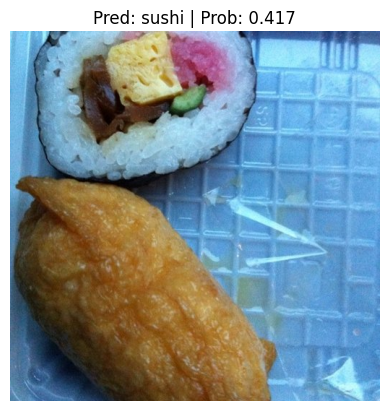

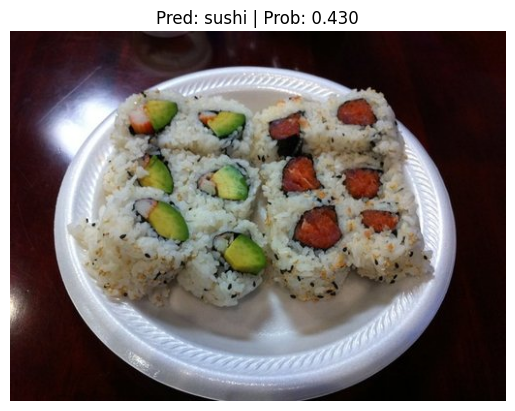

In [ ]:
five_most_wrong = list_path_prob[:5]

for path, label_prob in five_most_wrong:
    image = Image.open(path)
    plt.figure()
    plt.imshow(image)
    plt.title(f'Pred: {class_names[label_prob[0]]} | Prob: {label_prob[1]:.3f}')
    plt.axis(False)

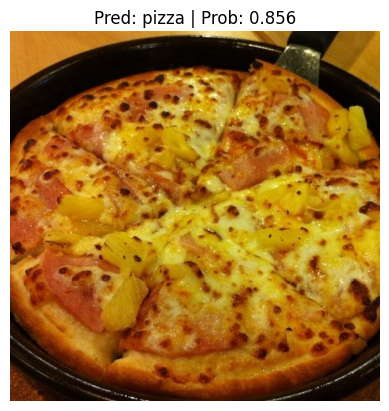

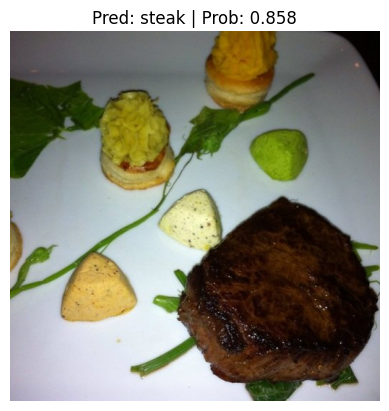

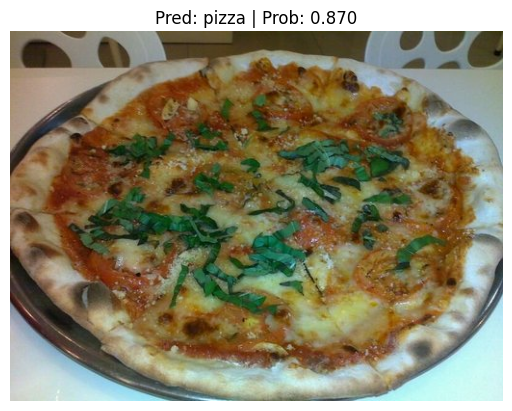

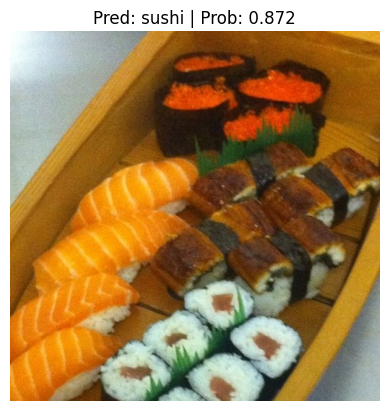

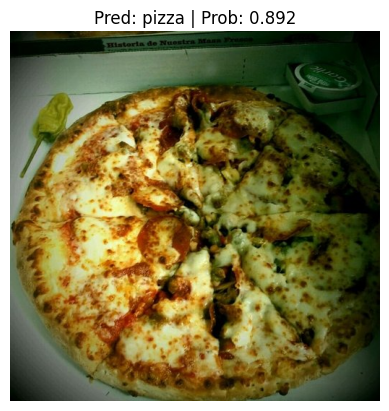

In [ ]:
five_most_right = list_path_prob[-5:]

for path, label_prob in five_most_right:
    image = Image.open(path)
    plt.figure()
    plt.imshow(image)
    plt.title(f'Pred: {class_names[label_prob[0]]} | Prob: {label_prob[1]:.3f}')
    plt.axis(False)

### Let's conduct a series of experiments
### Consider two models: efficientnet_b0, efficientnet_b2
### Will use: 10%, 20% train samples
### Will teach on: 5, 10 epochs

In [ ]:
# We've already known in_features for the efficientnet_b0 linear model (this is 1280)
# Now let's find out this parameter for the efficientnet_b2 model
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnet_b2 = torchvision.models.efficientnet_b2(weights=weights)

summary(model=effnet_b2,
        input_size=(32, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
# Create functions to create models efficientnet_b0, efficientnet_b0
# Creating with a function is necessary because in a loop we need a new model at each iteration
def create_effnet_b0():

    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    effnet_b0 = torchvision.models.efficientnet_b0(weights=weights)
    for param in effnet_b0.features.parameters():
        param.requires_grad = False
    helper.set_seeds()
    effnet_b0.classifier = nn.Sequential(nn.Dropout(p=.2),
                                         nn.Linear(in_features=1280,
                                                   out_features=NUM_CLASSES,
                                                   bias=True)).to(device)
    effnet_b0.name = 'effnet_b0'
    print(f'Created new {effnet_b0.name} model')
    return effnet_b0

def create_effnet_b2():

    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    effnet_b2 = torchvision.models.efficientnet_b2(weights=weights)
    for param in effnet_b2.features.parameters():
        param.requires_grad = False
    helper.set_seeds()
    effnet_b2.classifier = nn.Sequential(nn.Dropout(p=.3),
                                         nn.Linear(in_features=1408,
                                                   out_features=NUM_CLASSES,
                                                   bias=True)).to(device)
    effnet_b2.name = 'effnet_b2'
    print(f'Created new {effnet_b2.name} model')
    return effnet_b2

In [ ]:
# Download 10 percent and 20 percent training data
data_10_path = helper.download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
                                    destination='pizza_steak_sushi_10')
data_20_path = helper.download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip',
                                    destination='pizza_steak_sushi_20')

Did not find data/pizza_steak_sushi_10 directory, creating it
Unzipping pizza_steak_sushi.zip
Did not find data/pizza_steak_sushi_20 directory, creating it
Unzipping pizza_steak_sushi_20_percent.zip


In [ ]:
# Going to use the same custom transformation as in the previous section (custorm_transform)
# Create data loaders one test for both trains
train_dir_10 = data_10_path / 'train'
train_dir_20 = data_20_path / 'train'
test_dir = data_10_path / 'test'

train_data_loader_10, test_data_loader, class_names = helper.create_dataloaders(train_dir=train_dir_10,
                                                                                test_dir=test_dir,
                                                                                transform=custorm_transform,
                                                                                batch_size=BATCH_SIZE)
train_data_loader_20, test_data_loader, class_names = helper.create_dataloaders(train_dir=train_dir_20,
                                                                                test_dir=test_dir,
                                                                                transform=custorm_transform,
                                                                                batch_size=BATCH_SIZE)

print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_data_loader_10)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_data_loader_20)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(test_data_loader)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 3 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [ ]:
# Create steps lists
epochs = [5, 10]
train_data_loaders = {'10_percent': train_data_loader_10,
                      '20_percent': train_data_loader_20}
models = ['efficientnet_b0', 'efficientnet_b2']

In [ ]:
# Experiment
%%time

helper.set_seeds()
experiment_number = 0

for train_data_loader_name, train_data_loader in train_data_loaders.items():
    for epoch in epochs:
        for model_name in models:

            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {train_data_loader_name}")
            print(f"[INFO] Number of epochs: {epoch}")

            if model_name == 'efficientnet_b0':
                model = create_effnet_b0()
            else:
                model = create_effnet_b2()

            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

            results = helper.train(model=model,
                                   train_dataloader=train_data_loader,
                                   test_dataloader=test_data_loader,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   epochs=epoch,
                                   device=device)

            save_filepath = f'{model_name}_{train_data_loader_name}_{epoch}_epochs.pth'
            helper.save_model(model=model, target_dir='models', model_name=save_filepath)

            print('_'*100 + '\n')

[INFO] Experiment number: 1
[INFO] Model: efficientnet_b0
[INFO] DataLoader: 10_percent
[INFO] Number of epochs: 5
Created new effnet_b0 model


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train loss: 1.0564 | train accuracy: 0.4688 | test loss: 0.9015 | test accuracy: 0.4782
Epoch: 2 | train loss: 0.9304 | train accuracy: 0.5547 | test loss: 0.7984 | test accuracy: 0.6932
Epoch: 3 | train loss: 0.8171 | train accuracy: 0.6953 | test loss: 0.6695 | test accuracy: 0.8759
Epoch: 4 | train loss: 0.7350 | train accuracy: 0.7617 | test loss: 0.6444 | test accuracy: 0.8864
Epoch: 5 | train loss: 0.6784 | train accuracy: 0.7656 | test loss: 0.6367 | test accuracy: 0.9072
Model saved in models/efficientnet_b0_10_percent_5_epochs.pth
____________________________________________________________________________________________________

[INFO] Experiment number: 2
[INFO] Model: efficientnet_b2
[INFO] DataLoader: 10_percent
[INFO] Number of epochs: 5
Created new effnet_b2 model


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train loss: 1.0892 | train accuracy: 0.3359 | test loss: 0.9453 | test accuracy: 0.7102
Epoch: 2 | train loss: 0.8765 | train accuracy: 0.7969 | test loss: 0.8987 | test accuracy: 0.7225
Epoch: 3 | train loss: 0.8104 | train accuracy: 0.6992 | test loss: 0.8249 | test accuracy: 0.8352
Epoch: 4 | train loss: 0.6903 | train accuracy: 0.9141 | test loss: 0.7453 | test accuracy: 0.8665
Epoch: 5 | train loss: 0.6074 | train accuracy: 0.8984 | test loss: 0.6994 | test accuracy: 0.8665
Model saved in models/efficientnet_b2_10_percent_5_epochs.pth
____________________________________________________________________________________________________

[INFO] Experiment number: 3
[INFO] Model: efficientnet_b0
[INFO] DataLoader: 10_percent
[INFO] Number of epochs: 10
Created new effnet_b0 model


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train loss: 1.0564 | train accuracy: 0.4688 | test loss: 0.9015 | test accuracy: 0.4782
Epoch: 2 | train loss: 0.9304 | train accuracy: 0.5547 | test loss: 0.7984 | test accuracy: 0.6932
Epoch: 3 | train loss: 0.8171 | train accuracy: 0.6953 | test loss: 0.6695 | test accuracy: 0.8759
Epoch: 4 | train loss: 0.7350 | train accuracy: 0.7617 | test loss: 0.6444 | test accuracy: 0.8864
Epoch: 5 | train loss: 0.6784 | train accuracy: 0.7656 | test loss: 0.6367 | test accuracy: 0.9072
Epoch: 6 | train loss: 0.5871 | train accuracy: 0.7891 | test loss: 0.5834 | test accuracy: 0.8968
Epoch: 7 | train loss: 0.6183 | train accuracy: 0.7891 | test loss: 0.5444 | test accuracy: 0.8864
Epoch: 8 | train loss: 0.5403 | train accuracy: 0.8008 | test loss: 0.4768 | test accuracy: 0.8968
Epoch: 9 | train loss: 0.4885 | train accuracy: 0.8008 | test loss: 0.4707 | test accuracy: 0.9176
Epoch: 10 | train loss: 0.5147 | train accuracy: 0.8086 | test loss: 0.5353 | test accuracy: 0.8759
Model sav

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train loss: 1.0892 | train accuracy: 0.3359 | test loss: 0.9453 | test accuracy: 0.7102
Epoch: 2 | train loss: 0.8765 | train accuracy: 0.7969 | test loss: 0.8987 | test accuracy: 0.7225
Epoch: 3 | train loss: 0.8104 | train accuracy: 0.6992 | test loss: 0.8249 | test accuracy: 0.8352
Epoch: 4 | train loss: 0.6903 | train accuracy: 0.9141 | test loss: 0.7453 | test accuracy: 0.8665
Epoch: 5 | train loss: 0.6074 | train accuracy: 0.8984 | test loss: 0.6994 | test accuracy: 0.8665
Epoch: 6 | train loss: 0.6273 | train accuracy: 0.8047 | test loss: 0.6431 | test accuracy: 0.8570
Epoch: 7 | train loss: 0.5653 | train accuracy: 0.8086 | test loss: 0.6133 | test accuracy: 0.8769
Epoch: 8 | train loss: 0.4832 | train accuracy: 0.9570 | test loss: 0.5715 | test accuracy: 0.8873
Epoch: 9 | train loss: 0.4804 | train accuracy: 0.9336 | test loss: 0.5821 | test accuracy: 0.8769
Epoch: 10 | train loss: 0.4091 | train accuracy: 0.9492 | test loss: 0.5398 | test accuracy: 0.8769
Model sav

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train loss: 0.9652 | train accuracy: 0.5625 | test loss: 0.6631 | test accuracy: 0.8655
Epoch: 2 | train loss: 0.7174 | train accuracy: 0.8146 | test loss: 0.5644 | test accuracy: 0.9280
Epoch: 3 | train loss: 0.5389 | train accuracy: 0.8750 | test loss: 0.4747 | test accuracy: 0.9176
Epoch: 4 | train loss: 0.4867 | train accuracy: 0.8604 | test loss: 0.4555 | test accuracy: 0.8873
Epoch: 5 | train loss: 0.4350 | train accuracy: 0.8896 | test loss: 0.3677 | test accuracy: 0.9384
Model saved in models/efficientnet_b0_20_percent_5_epochs.pth
____________________________________________________________________________________________________

[INFO] Experiment number: 6
[INFO] Model: efficientnet_b2
[INFO] DataLoader: 20_percent
[INFO] Number of epochs: 5
Created new effnet_b2 model


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train loss: 0.9892 | train accuracy: 0.5292 | test loss: 0.7963 | test accuracy: 0.8049
Epoch: 2 | train loss: 0.7758 | train accuracy: 0.7479 | test loss: 0.6622 | test accuracy: 0.8561
Epoch: 3 | train loss: 0.6133 | train accuracy: 0.8333 | test loss: 0.5939 | test accuracy: 0.8873
Epoch: 4 | train loss: 0.4921 | train accuracy: 0.8854 | test loss: 0.5245 | test accuracy: 0.9384
Epoch: 5 | train loss: 0.4525 | train accuracy: 0.8979 | test loss: 0.4748 | test accuracy: 0.9384
Model saved in models/efficientnet_b2_20_percent_5_epochs.pth
____________________________________________________________________________________________________

[INFO] Experiment number: 7
[INFO] Model: efficientnet_b0
[INFO] DataLoader: 20_percent
[INFO] Number of epochs: 10
Created new effnet_b0 model


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train loss: 0.9652 | train accuracy: 0.5625 | test loss: 0.6631 | test accuracy: 0.8655
Epoch: 2 | train loss: 0.7174 | train accuracy: 0.8146 | test loss: 0.5644 | test accuracy: 0.9280
Epoch: 3 | train loss: 0.5389 | train accuracy: 0.8750 | test loss: 0.4747 | test accuracy: 0.9176
Epoch: 4 | train loss: 0.4867 | train accuracy: 0.8604 | test loss: 0.4555 | test accuracy: 0.8873
Epoch: 5 | train loss: 0.4350 | train accuracy: 0.8896 | test loss: 0.3677 | test accuracy: 0.9384
Epoch: 6 | train loss: 0.3611 | train accuracy: 0.9292 | test loss: 0.3761 | test accuracy: 0.8873
Epoch: 7 | train loss: 0.3367 | train accuracy: 0.9000 | test loss: 0.3204 | test accuracy: 0.9280
Epoch: 8 | train loss: 0.3353 | train accuracy: 0.9146 | test loss: 0.2849 | test accuracy: 0.9280
Epoch: 9 | train loss: 0.3535 | train accuracy: 0.8979 | test loss: 0.2876 | test accuracy: 0.9384
Epoch: 10 | train loss: 0.3366 | train accuracy: 0.9021 | test loss: 0.2915 | test accuracy: 0.9489
Model sav

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train loss: 0.9892 | train accuracy: 0.5292 | test loss: 0.7963 | test accuracy: 0.8049
Epoch: 2 | train loss: 0.7758 | train accuracy: 0.7479 | test loss: 0.6622 | test accuracy: 0.8561
Epoch: 3 | train loss: 0.6133 | train accuracy: 0.8333 | test loss: 0.5939 | test accuracy: 0.8873
Epoch: 4 | train loss: 0.4921 | train accuracy: 0.8854 | test loss: 0.5245 | test accuracy: 0.9384
Epoch: 5 | train loss: 0.4525 | train accuracy: 0.8979 | test loss: 0.4748 | test accuracy: 0.9384
Epoch: 6 | train loss: 0.4256 | train accuracy: 0.8729 | test loss: 0.4484 | test accuracy: 0.9176
Epoch: 7 | train loss: 0.4224 | train accuracy: 0.8500 | test loss: 0.4415 | test accuracy: 0.9280
Epoch: 8 | train loss: 0.3829 | train accuracy: 0.8500 | test loss: 0.3926 | test accuracy: 0.9384
Epoch: 9 | train loss: 0.3087 | train accuracy: 0.9417 | test loss: 0.4678 | test accuracy: 0.8674
Epoch: 10 | train loss: 0.3673 | train accuracy: 0.9104 | test loss: 0.3912 | test accuracy: 0.9280
Model sav

In [ ]:
# Load best model
best_model_path = 'models/efficientnet_b0_20_percent_10_epochs.pth'
best_model = create_effnet_b0()
best_model.load_state_dict(torch.load(best_model_path))

Created new effnet_b0 model


<All keys matched successfully>

In [ ]:
# Model size
Path(best_model_path).stat().st_size // (1024*1024)

15

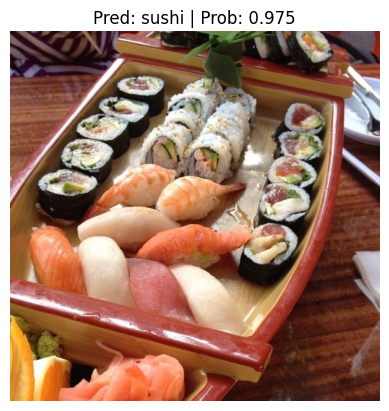

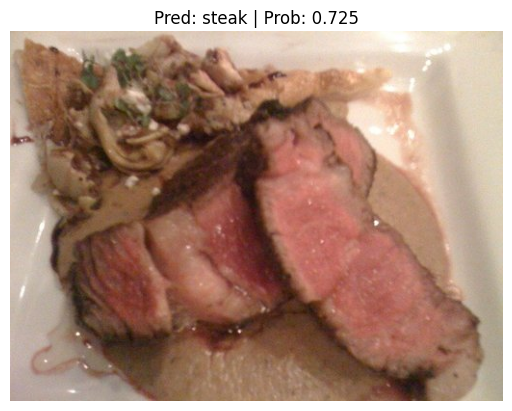

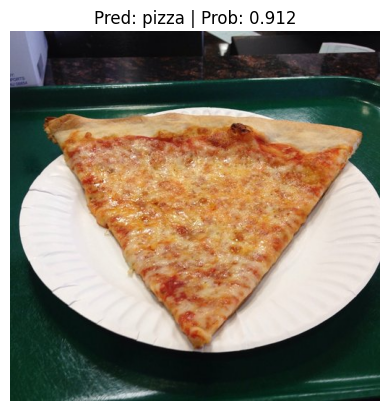

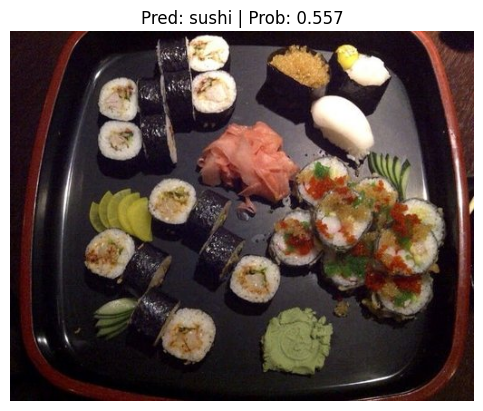

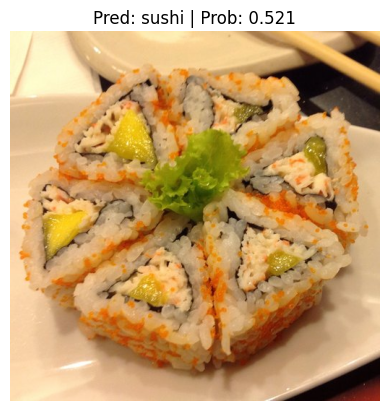

In [ ]:
# Make a prediction for random test images
# Generate n random images
n = 5
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=n)

for image_path in test_image_path_sample:
    helper.predict_and_mb_plot(model=best_model,
                               image_path=image_path,
                               class_names=class_names,
                               device=device,
                               make_plot=True)